# Project: Investigating a TMDb database: Q&A of a moviemaniac!

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

I'm interested in movies, so I've chosen the movie database. Although my favorite part is just sit back and relax, in this case what I'm interested in is the economic success of specific producers, actors, etc.

What I want to get from the data is the answers to the following:

 1) Which director can be named the best, when it comes to both financial success and popularity? I want this to be answered decade-wise, e.g. 60'ties, 70'ties, etc. all the way to the 21st century.
 
 2) Is there a correlation between budget and popularity, i.e. are better funded movies necessarily popular?

 3) How many movies did actorsplay in in the last 15 years?

 4) Considering TOP 100 actors who played in the most films, is there a correlation between their busy-ness and budget, i.e. do they tend to choose better paid productions?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import collections as cls
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [2]:
# Load your data and print out a few lines. Perform operations to inspect data
# types and look for instances of missing or possibly errant data.

movies = pd.read_csv("tmdb-movies.csv")
movies.head(3)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08


In [3]:
# Keep the interesting part: id, popularity, budget, revenue, original_title, cast, director,
# genres, production_companies, release_year
movies = movies[['id', 'popularity', 'budget', 'revenue', 'original_title', 'cast', 'director',
                 'runtime', 'genres', 'production_companies', 'release_year']]
movies.head(3)

,id,popularity,budget,revenue,original_title,cast,director,runtime,genres,production_companies,release_year
0,135397,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,2015
1,76341,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,2015
2,262500,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,2015


In [4]:
# Check for nulls and inspect data types
movies_d = movies.drop_duplicates(subset='id', inplace=False)
movies_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 11 columns):
id                      10865 non-null int64
popularity              10865 non-null float64
budget                  10865 non-null int64
revenue                 10865 non-null int64
original_title          10865 non-null object
cast                    10789 non-null object
director                10821 non-null object
runtime                 10865 non-null int64
genres                  10842 non-null object
production_companies    9835 non-null object
release_year            10865 non-null int64
dtypes: float64(1), int64(5), object(5)
memory usage: 1018.6+ KB


It looks good. There aren't many null data, so there will be much data to work on.
There are only 3 data types in the dataset: integers, float and strings (a.k.a. objects)

In [5]:
# There may still lurk unrealistic data, e.g. 0 budget. All integer data ('id' excluded) should be checked for that.
zero_budget = (movies_d.budget == 0).sum()
zero_revenue = (movies_d.revenue == 0).sum()
zero_runtime = (movies_d.runtime == 0).sum()
zeroth_release_year = (movies_d.release_year == 0).sum()
print('Unrealistic data: \n zero budget ({}), \n zero revenue ({}), \n zero runtime ({}), \n zeroth release_year ({})'.format(zero_budget, zero_revenue, zero_runtime, zeroth_release_year))

Unrealistic data: 
 zero budget (5696), 
 zero revenue (6016), 
 zero runtime (31), 
 zeroth release_year (0)


> The above values should be taken into account when answering a question of interest. For the sake of keeping the subset as big as possible, I've decided to prepare 4 datasets trimmed specifically for the purpose of each question. In some cases the zero values in budget, revenue and runtime were not taken into account. That way the set could be as large as ca. 10000 values. In others however both were needed, making the subset smaller - ca. 4500 values.

> The next section describes the questions posed and which data should be included in the subset.

### Data Cleaning - preparation of cleaned data subsets

#### Preparation of 4 subsets, each cleaned and trimmed to maximize the sample size and increase clarity.

1) Which director and what movie can be named the best of the decade, when it comes to both financial success and popularity? I want this to be answered decade-wise, e.g. 60'ties, 70'ties, etc. all the way to the 21st century.

 Subset_1: director, original_title, popularity, budget, revenue, id, release_year


2) Is there a correlation between budget and popularity, i.e. are better funded movies necessarily popular?

 Subset_2: budget, popularity, id


3) How many movies did actors play in in the last 15 years?

 Subset_3: id, cast, year


4) Considering TOP 15 actors from question 3, do they tend to choose better paid productions? (I will take a look into the entire history, not just the 15 years they were the bussiest)

 Data needed:
  - Subset_3 (list of 15 most frequently performing actors)
  - Subset_4 consisting of: id, cast, budget

In [6]:
# Computing subset_1

Subset_1 = movies[['director', 'original_title', 'popularity', 'budget', 'revenue', 'id', 'release_year']]

# Get rid of duplicates
Subset_1 = Subset_1.drop_duplicates()

# Drop null values
Subset_1 = Subset_1.dropna()

# Get rid of unrelistic data
Subset_1 = Subset_1.query('(budget > 0) & (revenue > 0)')

# Reset index
Subset_1 = Subset_1.reset_index()

# Create a ROI (Return of Investment) column
Subset_1['ROI'] = round((Subset_1.revenue - Subset_1.budget)/Subset_1.budget, 2)

# Double-check if the data looks good
Subset_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3853 entries, 0 to 3852
Data columns (total 9 columns):
index             3853 non-null int64
director          3853 non-null object
original_title    3853 non-null object
popularity        3853 non-null float64
budget            3853 non-null int64
revenue           3853 non-null int64
id                3853 non-null int64
release_year      3853 non-null int64
ROI               3853 non-null float64
dtypes: float64(2), int64(5), object(2)
memory usage: 271.0+ KB


In [7]:
# Computing Subset_2

Subset_2 = movies[['budget', 'popularity', 'id']]

# Get rid of duplicates
Subset_2 = Subset_2.drop_duplicates()

# Drop null values
Subset_2 = Subset_2.dropna()

# Get rid of unrelistic data
Subset_2 = Subset_2[Subset_2.budget > 0]

# Reset index
Subset_2 = Subset_2.reset_index()

# Double-check if the data looks good
Subset_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5169 entries, 0 to 5168
Data columns (total 4 columns):
index         5169 non-null int64
budget        5169 non-null int64
popularity    5169 non-null float64
id            5169 non-null int64
dtypes: float64(1), int64(3)
memory usage: 161.6 KB


In [8]:
# Computing Subset_3

Subset_3 = movies[['cast', 'release_year', 'id']]

# Get rid of duplicates
Subset_3 = Subset_3.drop_duplicates()

# Drop null values
Subset_3 = Subset_3.dropna()

# Reset index
Subset_3 = Subset_3.reset_index()

# Double-check if the data looks good
Subset_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Data columns (total 4 columns):
index           10789 non-null int64
cast            10789 non-null object
release_year    10789 non-null int64
id              10789 non-null int64
dtypes: int64(3), object(1)
memory usage: 337.2+ KB


In [9]:
# Create Subset_4
Subset_4 = movies[['budget', 'cast', 'id']]

# Get rid of duplicates
Subset_4 = Subset_4.drop_duplicates()

# Drop null values
Subset_4 = Subset_4.dropna()

# Get rid of unrelistic data
Subset_4 = Subset_4[Subset_4.budget > 0]

# Reset index
Subset_4 = Subset_4.reset_index()

# Double-check if the data looks good
Subset_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5158 entries, 0 to 5157
Data columns (total 4 columns):
index     5158 non-null int64
budget    5158 non-null int64
cast      5158 non-null object
id        5158 non-null int64
dtypes: int64(3), object(1)
memory usage: 161.3+ KB


<a id='eda'></a>
## Exploratory Data Analysis

### Which director and what movie can be named the best of the decade, when it comes to both financial success and popularity? I want this to be answered decade-wise, e.g. 60'ties, 70'ties, etc. all the way to the 21st century.

In [10]:
# Introduce a variable that will reflect simultaneously the financial and popularity success
# FPI - Financial & Popularity Index
# FPI = (Return of Investment)*Popularity / (10 yr max Return of Investment)*(10 yr max Popularity)
# FPI index takes values from 0 (when popularity OR Return of Investment are 0)
# to 1 (when popularity AND Return of Investment match the 10yr max values)


Bulls_eye = pd.DataFrame()
interval = 10

# The oldest release year and decade
minRY = min(Subset_1.release_year)
minDec = round(minRY, -1) - interval

# The latest release year and decade
maxRY = max(Subset_1.release_year)
maxDec = round(maxRY, -1)

# Define the iteration range - number of intervals in the span between the first and last release year
decade_range = int(round((maxDec - minDec)/interval, 0))

mROI = max(Subset_1.ROI)
mPop = max(Subset_1.popularity)
Subset_1['FPI'] = (Subset_1.ROI * Subset_1.popularity) / (mROI * mPop)

# Prepare empty lists for future columns
Decade = []
Release_year = []
Director = []
Title = []
FPI_index = []

for d in range(decade_range-1):
    decade = minRY + d*interval
    Sub = Subset_1[(Subset_1.release_year < (decade + interval)) & (Subset_1.release_year >= decade)]
    Decade.append(decade)
    Release_year.append((Sub.release_year[Sub.FPI == max(Sub.FPI)]).max())
    Director.append((Sub.director[Sub.FPI == max(Sub.FPI)]).max())
    Title.append((Sub.original_title[Sub.FPI == max(Sub.FPI)]).max())
    FPI_index.append(round(max(Sub.FPI), 6))

In [11]:
# Prepare a table with results - stack the Decade, Director and FPI into one dataframe
Bulls_eye = pd.DataFrame(np.column_stack([Decade, Release_year, Director, Title, FPI_index]), columns = ['Decade', 'Release_year', 'Director', 'Title', 'FPI-index'])
Bulls_eye

,Decade,Release_year,Director,Title,FPI-index
0,1960,1962,Terence Young,Dr. No,5e-06
1,1970,1977,George Lucas,Star Wars,2.5e-05
2,1980,1986,John G. Avildsen,"The Karate Kid, Part II",0.023419
3,1990,1999,Daniel Myrick|Eduardo SÃ¡nchez,The Blair Witch Project,0.000276
4,2000,2007,Oren Peli,Paranormal Activity,0.00043
5,2010,2011,Angel Gracia,From Prada to Nada,0.000371


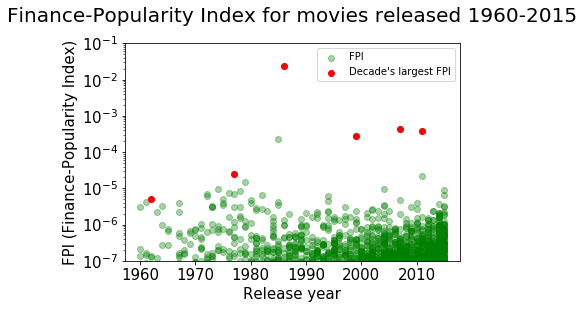

In [41]:
FPI_1 = plt.scatter(x=Subset_1.release_year, y=Subset_1.FPI, color='g', alpha=0.35);
FPI_max = plt.scatter(x=Release_year, y=FPI_index, color='r');
plt.yscale('log');
plt.ylim(0.0000001, 0.1);
plt.xlabel('Release year', size=15);
plt.ylabel('FPI (Finance-Popularity Index)', size=15);
plt.xticks(size=15);
plt.yticks(size=15);
plt.legend((FPI_1, FPI_max), ('FPI', "Decade's largest FPI"));
plt.title("Finance-Popularity Index for movies released 1960-2015" , y=1.07, size=20);

### Is there a correlation between budget and popularity, i.e. are better funded movies necessarily popular?

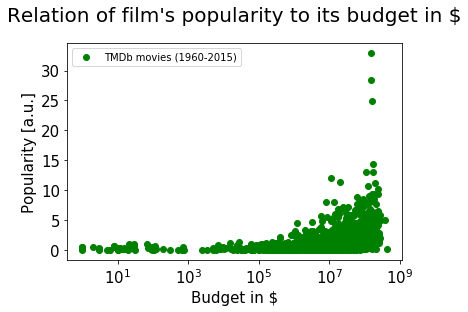

In [56]:
# Continue to explore the data to address your additional research
# questions. Add more headers as needed if you have more questions to
# investigate.

Second = plt.scatter(y=Subset_2.popularity, x=Subset_2.budget, c='g');
plt.xscale('log');
plt.xlabel('Budget in $', size=15);
plt.ylabel('Popularity [a.u.]', size=15);
plt.xticks(size=15);
plt.yticks(size=15);
plt.legend(["TMDb movies (1960-2015)"]);
plt.title("Relation of film's popularity to its budget in $" , y=1.07, size=20);

### How many movies did actors play in in the last 15 years?

In [14]:
# Computing a dictionary of actors (and the number of films they starred in) for question #3

Actors_count = {}
Cast = []
Cast_na = movies.cast.dropna().unique()
for n in range(len(Cast_na)-1):
    Cast_id = (Cast_na[n]).split(sep='|')
    for j in Cast_id:
        if j in Cast:
            next
        else:
            Actors_count[j] = 0
            
# Count the number of films each actor played in the last 15 years
Subset_3_15yrs = Subset_3.query('release_year >= 2000')
Cast_15yrs = Subset_3_15yrs.cast.dropna().unique()

for f in range(len(Cast_15yrs)-1):
    Cast_id = (Cast_na[f]).split(sep='|')
    for j in Cast_id:
        Actors_count[j] += 1

In [15]:
# Compute the mean, mode and median of the number of movies actors played in the last 15 years.

import statistics
print('Mode: ',statistics.mode(list(Actors_count.values())),'\n','Mean: ', statistics.mean(list(Actors_count.values())),'\n','Median: ', statistics.median(list(Actors_count.values())))

Mode:  1 
 Mean:  1.7982230166657904 
 Median:  1


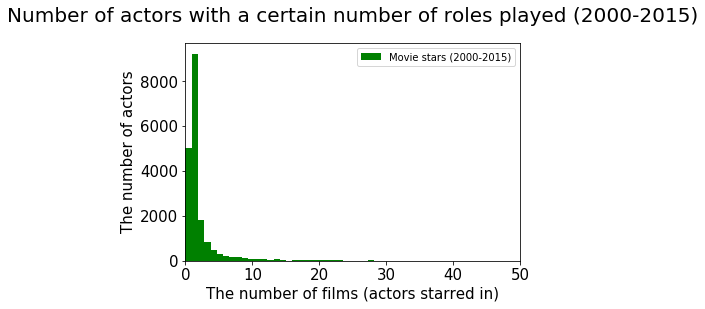

In [58]:
# Build a histogram to show the tendency in starring in films

plt.hist(Actors_count.values(), color='g', bins=50);
plt.xlabel('The number of films (actors starred in)', size=15);
plt.ylabel('The number of actors', size=15);
plt.xticks(size=15);
plt.yticks(size=15);
plt.xlim(0,50);
plt.legend(["Movie stars (2000-2015)"]);
plt.title("Number of actors with a certain number of roles played (2000-2015)" , y=1.07, size=20);

### Considering TOP 15 actors from question 3, do they tend to choose better paid productions? (I will take a look into the entire history, not just the 15 years they were the bussiest)

In [17]:
# Generate statistics to answer the question.

# Get 15 highest scored Actors
Actors_order = cls.OrderedDict(sorted(Actors_count.items(), key=lambda x: x[1], reverse=True))

Akeys = list(Actors_order.keys())
Avals = list(Actors_order.values())

# Get the actual list of top 15 actors; 
TOP15_actors = Akeys[0:15]
for k in range(15, len(Akeys)-1):
    if Avals[k] < Avals[len(TOP15_actors)-1]:
        break
    else:
        TOP15_actors.append(Akeys[k])

# Get the count of the movies these top 15 stars played in the last 15 years
TOP15_count = Avals[:(len(TOP15_actors))]

TOP15 = pd.DataFrame()
TOP15['Actors'] = TOP15_actors
TOP15['Movies_stared'] = TOP15_count
TOP15

,Actors,Movies_stared
0,Samuel L. Jackson,47
1,Robert De Niro,40
2,John Cusack,39
3,Bruce Willis,38
4,James Franco,38
5,Nicolas Cage,38
6,Julianne Moore,35
7,Ewan McGregor,34
8,Liam Neeson,33
9,Johnny Depp,33


In [18]:
# Filter Subset_4 using TOP15_actors list

Actor_budget = {}
for j in TOP15_actors:
    Actor_budget[j] = []

for g in range(Subset_4.shape[0]):
    for actor in TOP15_actors:
        if actor in Subset_4.cast[g]:
            Actor_budget[actor].append(Subset_4.budget[g])

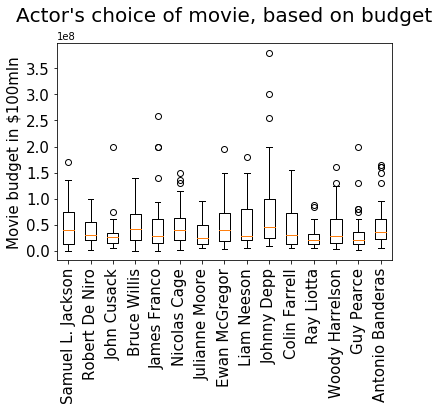

In [31]:
# Generate a handful of boxplots to better read the situation
plt.boxplot(Actor_budget.values(), labels=Actor_budget.keys());
plt.xticks(rotation=90, size=15);
plt.yticks(size=15);
plt.ylabel('Movie budget in $100mln', size=15);
plt.title("Actor's choice of movie, based on budget" , y=1.07, size=20);

<a id='conclusions'></a>
## Conclusions

## General problems faced when dealing with the analysis
> This concerns most of the Subsets and all questions posed, so I've decided to cram it into one paragraph. The existence of Nulls and duplicates is something I can live with - they did not pose too much of a problem to work with but indeed made the dataset very small in some cases. In my opinion, cutting the number of entries by half was a pain to look at - I like my data large when analysis is performed.
> But above all I think it was the unrealistic and useless values meddled between the good ones, e.g. 0 runtime, 0 budget. These can be tricky to work with. I've filtered the obvious ones, e.g. runtime = 0 minutes, but there may be many others, difficult to deal with, e.g. budget <1000 dollars. What if those movies were shot with a low or extremely low budget? "The Blair Witch Project" is a good example of that - 25000 dollars. Thus, setting a proper low limit was definitely something I found challenging. And a bit distasteful, when a decision was to be made when not enough information was provided and the data was not to be trusted 50% of the time...

### Question 1
> This seems pretty reasonable - Dr. No, Karate Kid, Star Wars and The Blair Witch Project are awesome films and the ones that were engraved deep into the viewer minds. It's obvious they got into the top of their decade. It's interesting to see that the older films (from the 60'ties) were usually better at gaining a simultaneous financial and popularity success. Although there were relatively less movies in those days, there were many successful to Dr. No. The more we close in to the current millenium, the wider the FPI gap gets between good and poor movies. Moreover, the three hits: "The Blair Witch Project", "Paranormal Activity" and "From Prada to Nada" are way above all other movies. This suggests that in the 21st century we observe a tendency of making movies that are either:
- popular but don't hit a high revenue (a niche),
- hit a high revenue but are not that popular (cinema hits but not so fun to watch at home e.g. Avatar
- are both unpopular and were a financial disaster

### Question 2
> There seems to be a tendency for films to gain more popularity when the budget is increased, but it's not that obvious. Having a small budget results usually in lower popularity but higher budget does not imply higher popularity. It mearly increases the chances of a bigger financial success.
### Question 3
> From the histogram we can coclude that a vast majority of actors played at most in 2 movies. There's a handful of names that hit above 30 movies (that's 2 movies per year!!!). The histogram is strongly right-skewed with a mode and median of 1 and a mean of 1.798.
### Question 4
> Samuel L. Jackson, Robert de Niro and John Cucack land on the podium... I'm glad at least one woman representative made it to the TOP15. Julianne Moore potrayed many great characters, FBI agent in Hannibal to name one. It's fairly obvious for the case of John Cusack and Ray Liotta - these guys tend to choose productions with a budget below 50mln dolars. It's more difficult to tell in other cases though... The TOP15 stars usually played in films with budgets below 100mln dollars, although tended to pick roles in films exceeding this value. A good example here is Johny Depp, who takes roles in movies with budget closing in to 400mln dollars! And there's Ray Liotta, who played exclusively in films with budget below 100mln dollars.

In [60]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0